In [1]:
import numpy as np
import scipy
from scipy.sparse import csr_matrix, lil_matrix
from scipy.special import gamma
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from findiff import FinDiff, Identity, PDE, BoundaryConditions
import plotly.graph_objects as go

In [2]:
def operator_to_matrix(diff_op, shape):
    """
    Convert a findiff operator into a precision matrix
    """
    mat = lil_matrix(diff_op.matrix(shape))
    interior_idxs = get_interior_indices(shape)
    mat = mat[interior_idxs]
    mat = mat[:, interior_idxs]
    mat = csr_matrix(mat)
    return mat

def get_domain_indices(shape):
    """
    Get grid indices
    """
    siz = np.prod(shape)
    full_indices = np.array(list(range(siz))).reshape(shape)
    return full_indices


def get_interior_indices(shape):
    """
    Get indices for domain interior
    """
    full_indices = get_domain_indices(shape)
    interior_slice = tuple(slice(1,-1) for _ in range(len(shape)))
    interior_indices = full_indices[interior_slice].flatten()
    return interior_indices

In [3]:
# Generate data from heat equation

# Set config params
grid_size = 25
time_size = 10
W_amp = 0

# Init fd = y = np.linspace(0, 1, grid_size)
t = np.linspace(0, 1, time_size)
X, Y, T = np.meshgrid(x, y, t, indexing='ij')
X_test = np.stack([X.flatten(), Y.flatten(), T.flatten()], axis=1)
shape = (grid_size, grid_size, time_size)
dx = x[1]-x[0]
dy = y[1]-y[0]
dt = t[1]-t[0]

In [4]:
# Set LHS
alpha = 0.05
diff_op = FinDiff(2, dt, 1) - alpha * (FinDiff(0, dx, 2) + FinDiff(1, dy, 2))

# Set RHS
np.random.seed(13)
W = W_amp * np.random.randn(*shape)

# Set boundary conditions (Dirichlet)
bc = BoundaryConditions(shape)
bc[:,:,0] = 0
bc[0, :, :] = 10
bc[-1,:,:] = 0
bc[:, 0,:] = 0
bc[:, -1,:] = 0

# Solve PDE
pde = PDE(diff_op, W, bc)
u = pde.solve()
bc

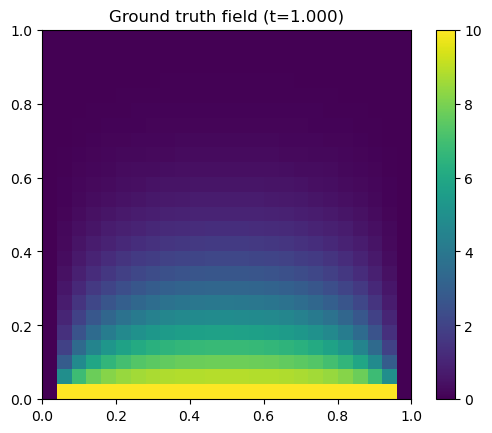

In [12]:
# Create animation
fig = plt.figure()
ax = plt.axes(xlim=(0, 1), ylim=(0, 1))
im = ax.imshow(u[:,:,0], extent=[0,1,1,0], animated=True)
plt.colorbar(im) # not animated but OK in this case

def animate(i):
    im.set_array(u[:,:,i])
    ax.set_title(f'Ground truth field (t={(dt*i):02.3f})')
    return im,

anim = animation.FuncAnimation(fig, animate, frames=10, interval=200, blit=True)
HTML(anim.to_jshtml())

In [6]:
fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=T.flatten(),
    value=u.flatten(),
    isomin=0.1,
    isomax=0.8,
    opacity=0.1, # needs to be small to see through all surfaces
    surface_count=17, # needs to be a large number for good volume rendering
    ))
fig.update_layout(
    autosize=False,
    width=600, 
    height=500,
    margin=dict(l=0,r=0,t=0,b=0),
    scene_camera=dict(eye=dict(x=2.0, y=2.0, z=0.75)),
    scene=dict(
        xaxis_title='x',
        yaxis_title='y',
        zaxis_title='t',
    ),
)
fig.show()


In [7]:
num_obs = 200
obs_noise = 1e-4

# Get observations at random locations
rng = np.random.default_rng(0)
x_idxs = y_idxs = np.arange(grid_size)
t_idxs = np.arange(time_size)
X_idxs, Y_idxs, T_idxs = np.meshgrid(x_idxs[1:-1], y_idxs[1:-1], t_idxs[1:-1], indexing='ij')
all_idxs = np.stack([X_idxs.flatten(), Y_idxs.flatten(), T_idxs.flatten()], axis=1)
idxs = rng.choice(all_idxs, num_obs, replace=False)
obs_dict = {tuple(idx): u[tuple(idx)]+obs_noise*np.random.randn() for idx in idxs}

In [14]:
# Construct precision matrix corresponding to the linear differential operator
mat = operator_to_matrix(diff_op, shape)
prior_precision = (dx * dy * dt) * mat.T @ mat # from noise discretisation
print(prior_precision.shape)
# prior_precision = (dx * dy) * mat.T @ mat

# Compute posterior mean and covariance
N = np.prod(shape)
interior_idxs = get_interior_indices(shape)
grid_indices = get_domain_indices(shape)

mask = np.zeros(N)
for idx in idxs:
    mask[grid_indices[tuple(idx)]] = 1
posterior_precision = prior_precision + csr_matrix(obs_noise**(-2) * np.diag(mask[interior_idxs]))
posterior_shift = np.zeros(np.prod(shape))
for idx in idxs:
    posterior_shift[grid_indices[tuple(idx)]] = obs_dict[tuple(idx)]/obs_noise**2
posterior_shift = posterior_shift[interior_idxs]
posterior_shift = csr_matrix(posterior_shift).T

posterior_mean_interior = scipy.sparse.linalg.spsolve(posterior_precision, posterior_shift)
posterior_cov_interior = scipy.sparse.linalg.inv(posterior_precision)

posterior_mean = np.zeros(N)
posterior_mean[interior_idxs] = posterior_mean_interior
posterior_mean = posterior_mean.reshape(shape)

posterior_std = np.zeros(N)
posterior_std[interior_idxs] = np.sqrt(posterior_cov_interior.diagonal())
posterior_std = posterior_std.reshape(shape)

(4232, 4232)


In [9]:
fig = go.Figure(data=[go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=T.flatten(),
    value=posterior_mean.flatten(),
    isomin=0.1,
    isomax=0.8,
    opacity=0.1, # needs to be small to see through all surfaces
    surface_count=17, # needs to be a large number for good volume rendering
    ), go.Scatter3d(x=dx*idxs[:,0], y=dy*idxs[:,1], z=dt*idxs[:,2], mode='markers')])
fig.update_layout(
    autosize=False,
    width=600, 
    height=500,
    margin=dict(l=0,r=0,t=0,b=0),
    scene_camera=dict(eye=dict(x=2.0, y=2.0, z=0.75)),
    scene=dict(
        xaxis_title='x',
        yaxis_title='y',
        zaxis_title='t',
    ),
)
fig.show()

In [10]:
fig = go.Figure(data=[go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=T.flatten(),
    value=posterior_std.flatten(),
    isomin=0.1,
    isomax=0.8,
    opacity=0.1, # needs to be small to see through all surfaces
    surface_count=17, # needs to be a large number for good volume rendering
    ), go.Scatter3d(x=dx*idxs[:,0], y=dy*idxs[:,1], z=dt*idxs[:,2], mode='markers')])
fig.update_layout(
    autosize=False,
    width=600, 
    height=500,
    margin=dict(l=0,r=0,t=0,b=0),
    scene_camera=dict(eye=dict(x=2.0, y=2.0, z=0.75)),
    scene=dict(
        xaxis_title='x',
        yaxis_title='y',
        zaxis_title='t',
    ),
)
fig.show()